In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import pandas as pd
# disable setting with copy warning
pd.options.mode.chained_assignment = None
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import pydicom

In [33]:
def get_group_by_pv(pv):
    if pv == "age":
        groups = ["old", "young"]
    else:
        groups = ["male", "female"]
    return groups

In [34]:
groups = get_group_by_pv("age")
metric = (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC")

In [35]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    sample_dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        # get last number from directory name
        train_loader_num = int(d.split('_')[-1])
        for seed in seeds:
            #print(os.path.join(d,seed))
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            sample_info = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('train_loader')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            sample_df = pd.read_csv(os.path.join(d, seed, sample_info))
            results_df["train_loader_num"] = train_loader_num
            sample_df["train_loader_num"] = train_loader_num
            dfs.append(results_df)
            sample_dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True), pd.concat(sample_dfs, ignore_index=True)

In [36]:
df_1_fae, df_samples_1_fae= load_csvs_into_df('./')
df_1_fae["model"] = "FAE"

df_1_rd, df_samples_1_rd = load_csvs_into_df('./' )
df_1_rd["model"] = "RD"

In [37]:
df_1 = pd.concat([df_1_fae, df_1_rd], ignore_index=True)

In [38]:
df = df_1[['seed','protected_attr_percent',*metric,'train_loader_num','model']]
df = pd.melt(df, id_vars=['seed','protected_attr_percent','train_loader_num','model'])
df = df.loc[(df["variable"]==f"test/lungOpacity_{groups[0]}_subgroupAUROC") | (df["variable"] == f"test/lungOpacity_{groups[1]}_subgroupAUROC")]
df.head()

seed  protected_attr_percent  train_loader_num model  \
0     1                     0.5              1068   FAE   
1     1                     0.5              1071   FAE   
2     1                     0.5               502   FAE   
3     1                     0.5              1218   FAE   
4     1                     0.5               201   FAE   

                             variable   value  
0  test/lungOpacity_old_subgroupAUROC  0.5882  
1  test/lungOpacity_old_subgroupAUROC  0.6630  
2  test/lungOpacity_old_subgroupAUROC  0.5444  
3  test/lungOpacity_old_subgroupAUROC  0.5446  
4  test/lungOpacity_old_subgroupAUROC  0.5256

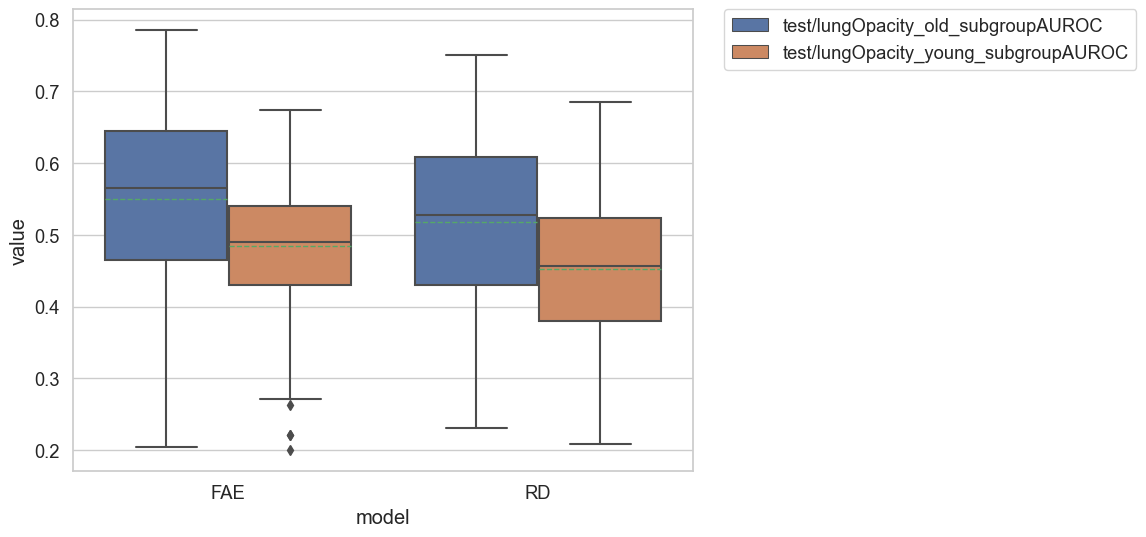

In [39]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="model", y="value", hue="variable", meanline=True, showmeans=True)
# legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [46]:
def get_best_and_worst(d, d_samples, group=0, num_samples=5):
    best = d[["train_loader_num",f"test/lungOpacity_{groups[group]}_subgroupAUROC"]].sort_values(by=f"test/lungOpacity_{groups[group]}_subgroupAUROC", ascending=False).iloc[:num_samples]
    best.rename(columns={f"test/lungOpacity_{groups[group]}_subgroupAUROC":"value"}, inplace=True)
    best.sort_values(by="train_loader_num", ascending=True, inplace=True)
    best_samples = d_samples.loc[d_samples["train_loader_num"].isin(best["train_loader_num"].values)]
    best_samples.sort_values(by="train_loader_num", ascending=True, inplace=True)
    
    worst = d[["train_loader_num",f"test/lungOpacity_{groups[group]}_subgroupAUROC"]].sort_values(by=f"test/lungOpacity_{groups[group]}_subgroupAUROC", ascending=True).iloc[:num_samples]
    worst.rename(columns={f"test/lungOpacity_{groups[group]}_subgroupAUROC":"value"}, inplace=True)
    worst.sort_values(by="train_loader_num", ascending=True, inplace=True)
    worst_samples = d_samples.loc[d_samples["train_loader_num"].isin(worst["train_loader_num"].values)]
    worst_samples.sort_values(by="train_loader_num", ascending=True, inplace=True)
    return best, best_samples, worst, worst_samples

In [41]:
def plot_xrays(d, d_samples, num_imgs=5, group=0, title_prefix=""):
    fig, axs = plt.subplots(1, num_imgs, figsize=(5*num_imgs,num_imgs))
    for i in range(0,num_imgs):
        file_path = d_samples["filenames"].values[i]
        file_path = "../." + file_path
        ds = pydicom.dcmread(file_path)
        axs[i].imshow(ds.pixel_array, cmap=plt.cm.bone)
        # add score as title
        score = d["value"].values[i] if len(d) > 1 else d["value"].values[0]
        axs[i].set_title(f"{title_prefix} {groups[group]} score: {score:.4f}")
        axs[i].grid(False)

In [42]:
def subset_by_trainloader(d,d_samples, train_loader_idx=0):
    chosen_train_loader_num = d.iloc[train_loader_idx]["train_loader_num"]
    d_samples = d_samples.loc[d_samples["train_loader_num"]==chosen_train_loader_num]
    d = d.loc[d["train_loader_num"]==chosen_train_loader_num]
    return d, d_samples

# Details num_samples=1
## FAE

      train_loader_num   value
617                 16  0.6592
496                122  0.6728
1241               640  0.6724
410                762  0.6742
731               1183  0.6658


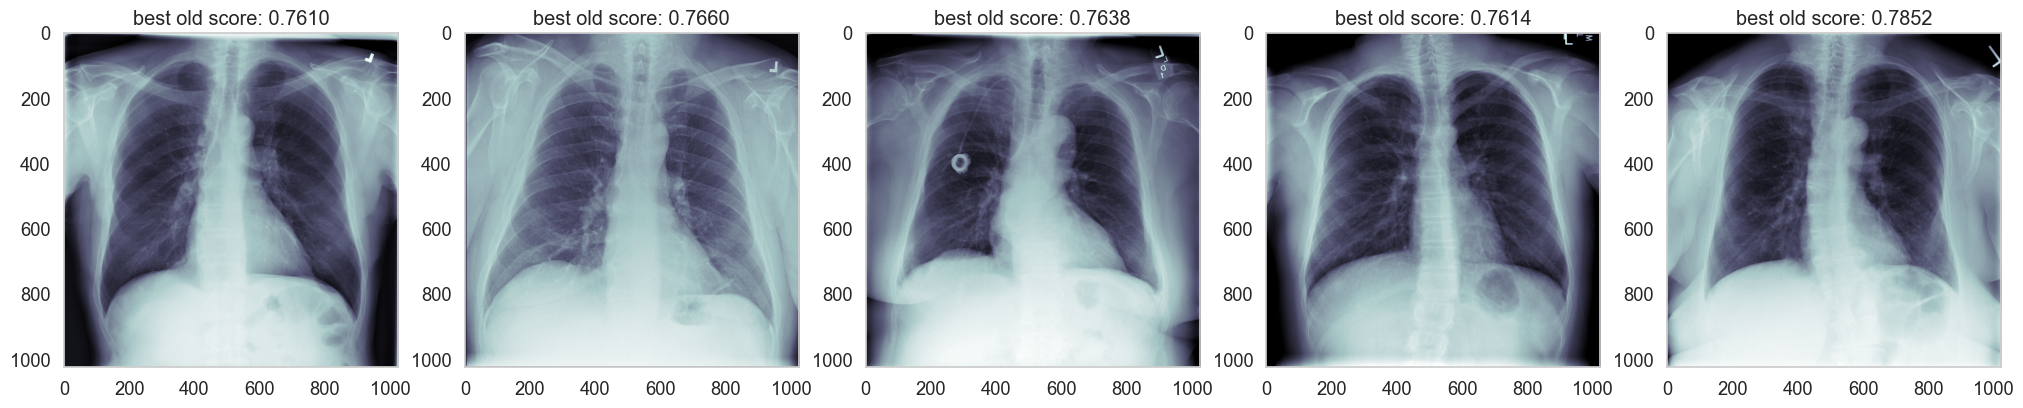

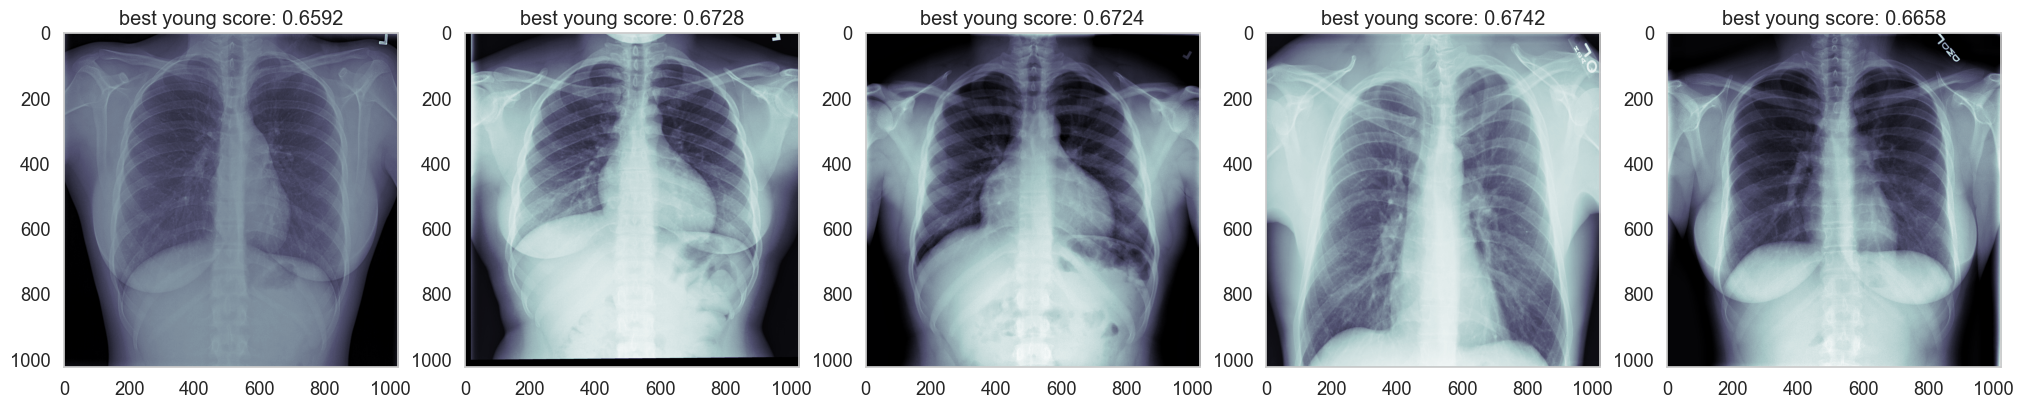

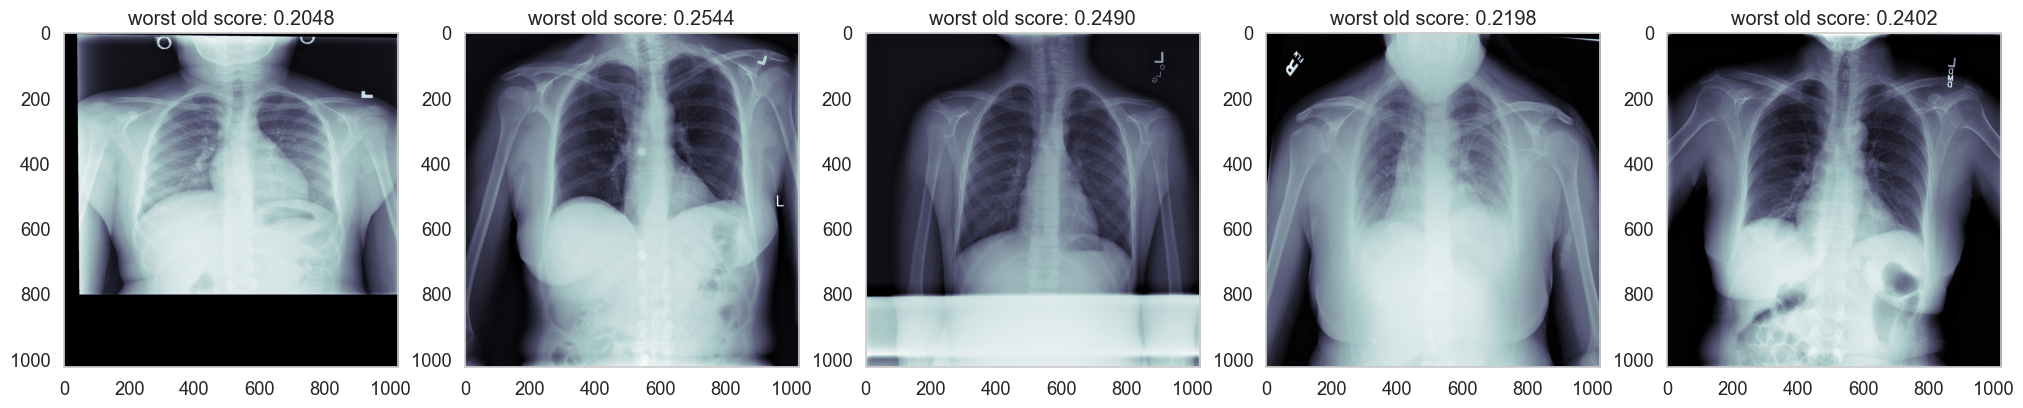

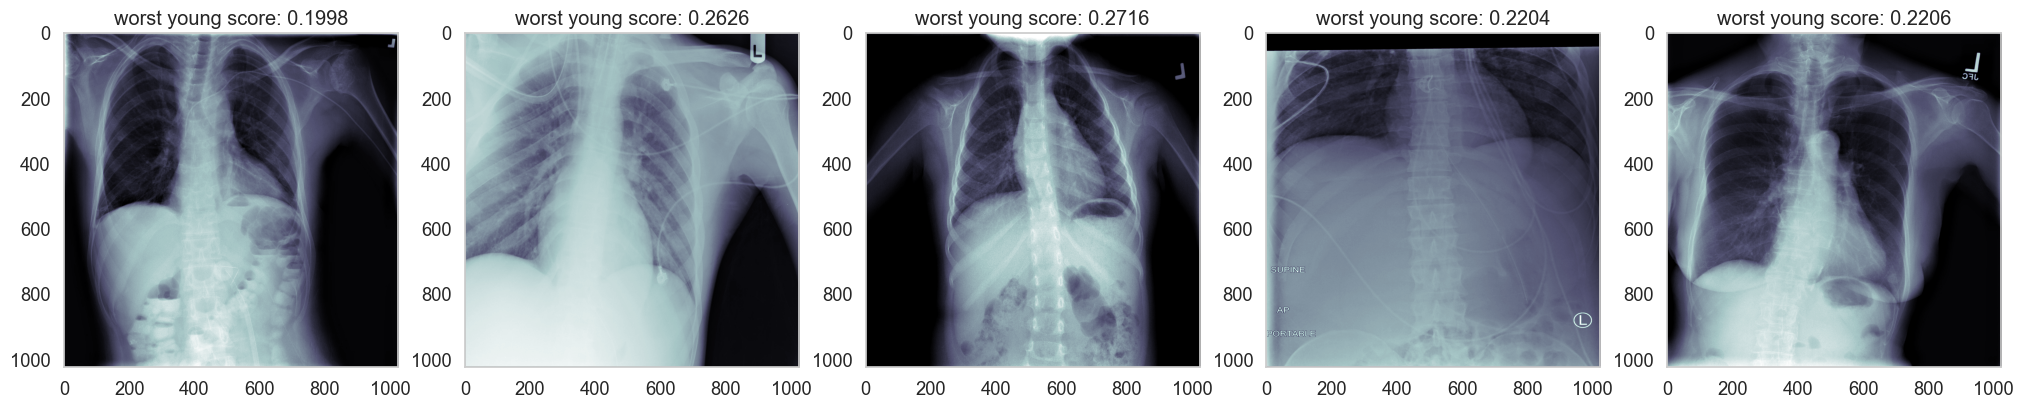

In [43]:
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_1_fae, df_samples_1_fae, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_1_fae, df_samples_1_fae, group=1)
print(best_old)
print(best_young)
plot_xrays(best_old, best_old_samples, group=0, title_prefix="best")
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best")
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst")
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst")

## RD

      train_loader_num   value
1057               313  0.6840
1196               339  0.6582
310                639  0.6858
187                851  0.6616
176               1020  0.6570


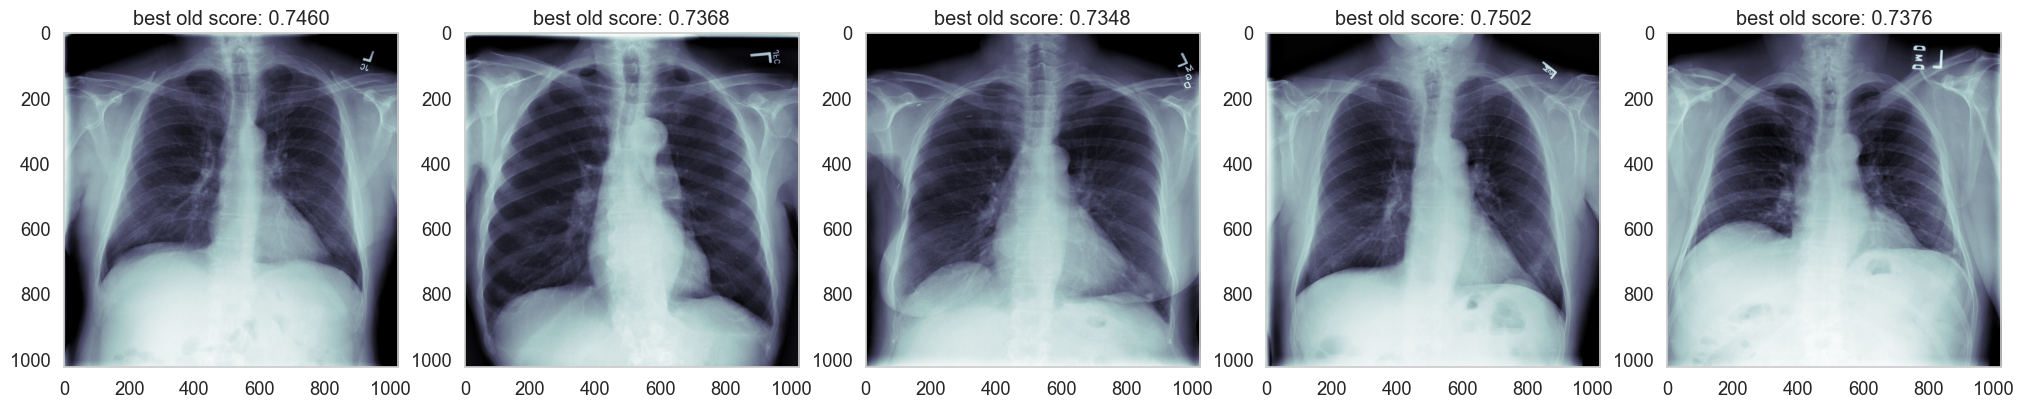

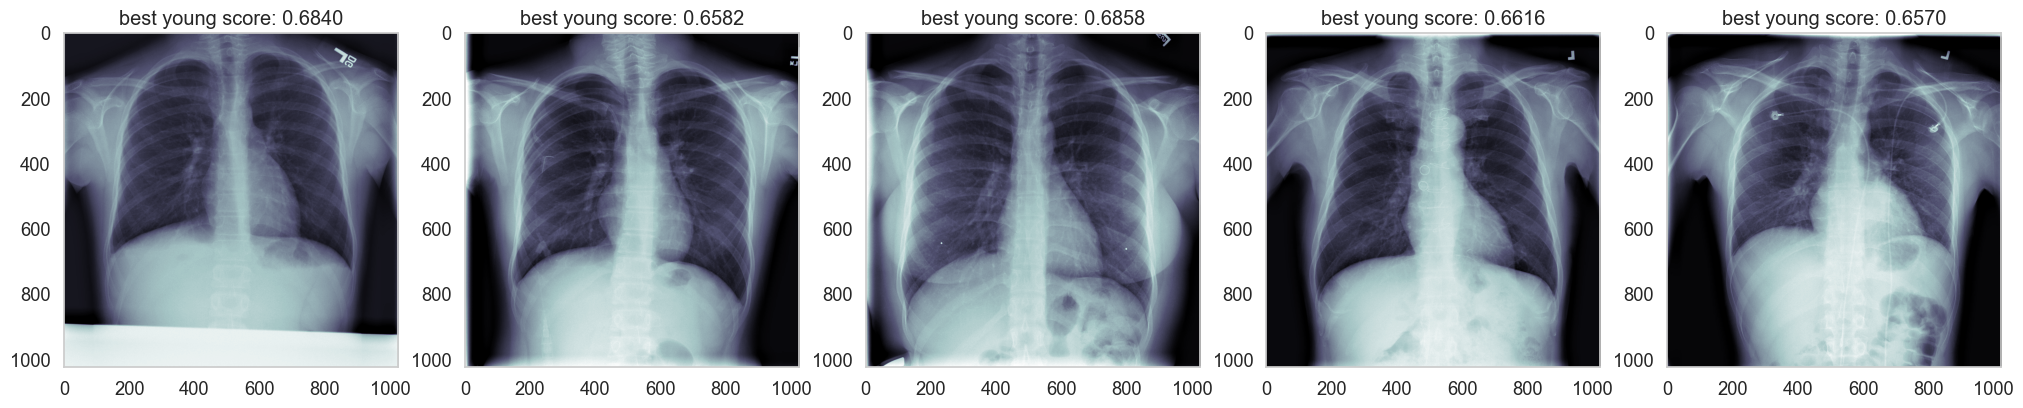

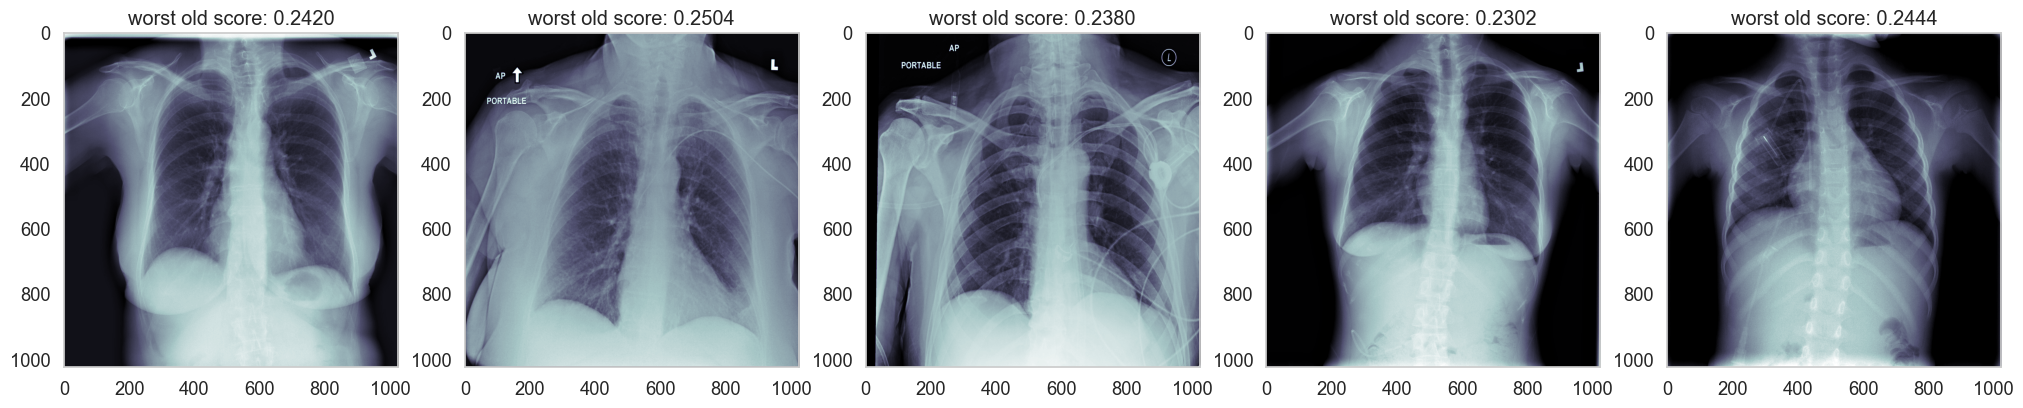

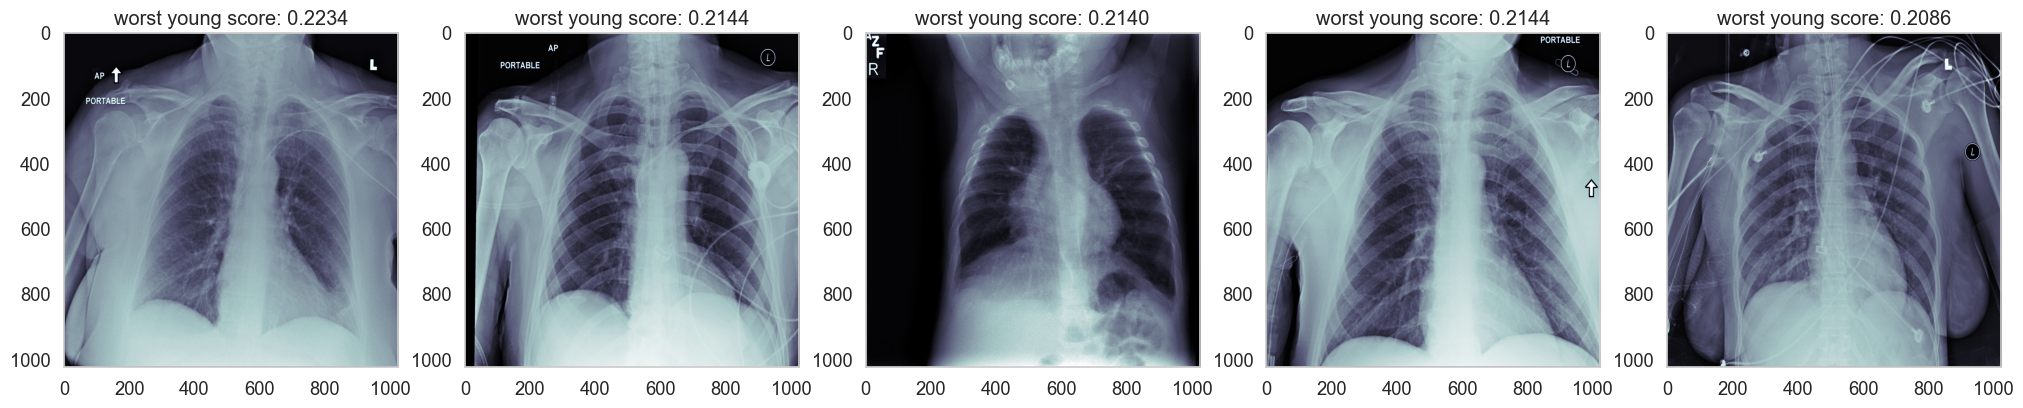

In [44]:
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_1_rd, df_samples_1_rd, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_1_rd, df_samples_1_rd, group=1)
print(best_old)
print(best_young)
plot_xrays(best_old, best_old_samples, group=0, title_prefix="best")
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best")
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst")
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst")

## Compute overlap

In [58]:
_, best_old_samples_rd, _, _ = get_best_and_worst(df_1_rd, df_samples_1_rd, group=0, num_samples=100)
_, best_young_samples_rd, _, _ = get_best_and_worst(df_1_rd, df_samples_1_rd, group=1, num_samples=100)

In [59]:
_, best_old_samples_fae, _, _ = get_best_and_worst(df_1_fae, df_samples_1_fae, group=0, num_samples=100)
_, best_young_samples_fae, _, _ = get_best_and_worst(df_1_fae, df_samples_1_fae, group=1, num_samples=100)

In [60]:
print("Best young samples overlap:", len(set(best_young_samples_rd["filenames"].values).intersection(set(best_young_samples_fae["filenames"].values))), "samples")

Best young samples overlap: 31 samples


In [61]:
print("Best old samples overlap:", len(set(best_old_samples_rd["filenames"].values).intersection(set(best_old_samples_fae["filenames"].values))), "samples")

Best old samples overlap: 20 samples
